In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, to_rgb
from matplotlib import rcParams, cycler
from tqdm import tqdm

colors = ['tab:purple', 'tab:blue', 'tab:red', 'tab:green']
colors_ens = ['tab:blue', 'tab:blue', 'tab:red', 'tab:blue']
colors_grad = [
    to_rgb('tab:purple'), 
    (np.array(to_rgb('tab:purple')) + np.array(to_rgb('tab:red'))*1.5 )/2.5, 
    to_rgb('tab:blue'), 
    (np.array(to_rgb('tab:blue')) + np.array(to_rgb('tab:red'))*1.5 )/2.5, 
    to_rgb('tab:red'), 
    to_rgb('tab:blue')]
rcParams['axes.prop_cycle'] = cycler(color=colors)

In [2]:
EVENTS = np.array(["MOVED_LEFT", "MOVED_RIGHT", "MOVED_UP", "MOVED_DOWN", "WAITED", "INVALID_ACTION", "BOMB_DROPPED", "BOMB_EXPLODED", "CRATE_DESTROYED", "COIN_FOUND", "COIN_COLLECTED", "KILLED_OPPONENT", "KILLED_SELF", "GOT_KILLED", "OPPONENT_ELIMINATED", "SURVIVED_ROUND"])
ACTIONS = np.array(['UP', 'RIGHT', 'DOWN', 'LEFT', 'WAIT', 'BOMB'])
color0 = np.array(plt.get_cmap("viridis")(0))
color0[:3] /= 2

In [3]:
e = {}
names_wide = {"e": "ensemble             ", "i": "imitator16            ", "m": "miniDQN              ", "r": "rule_based_agent"}
names = {"e": "ensemble", "i": "imitator16", "m": "miniDQN", "r": "rule_based_agent"}


with open("imitator16/evaluation2.pt", "rb") as file:
    e["i"] = pickle.load(file)
with open("miniDQN2/evaluation2.pt", "rb") as file:
    e["m"] = pickle.load(file)
with open("ensemble2/evaluation2.pt", "rb") as file:
    e["e"] = pickle.load(file)
with open("rule_based_agent/evaluation2.pt", "rb") as file:
    e["r"]= pickle.load(file)

print(f'Total number of rounds: {len(e["e"]["events"])}')
total_n_transitions = 0
for stuck in e["e"]["stuck"]:
    for _ in stuck:
        total_n_transitions += 1
print(f'Total number of ensemble transitions: {total_n_transitions}\n')

for k in e["e"].keys(): print(k)

Total number of rounds: 1751
Total number of ensemble transitions: 229508

events
p_imitator
Q_miniDQN
proposed_action_imitator
proposed_action_miniDQN
proposed_action_imitator_was_valid
proposed_action_miniDQN_was_valid
confidence_imitator
confidence_miniDQN
normalized_confidence_ensemble
stuck
action_proposed


# Rewards

In [4]:
rewards_each_round = {k: [] for k in e.keys()}
for k in e.keys():
    for r in e[k]["events"]:
        score = 0

        for s in r:
            for ev in s:
                if ev == "COIN_COLLECTED": score += 1
                elif ev == "KILLED_OPPONENT": score += 5

        rewards_each_round[k].append(score)

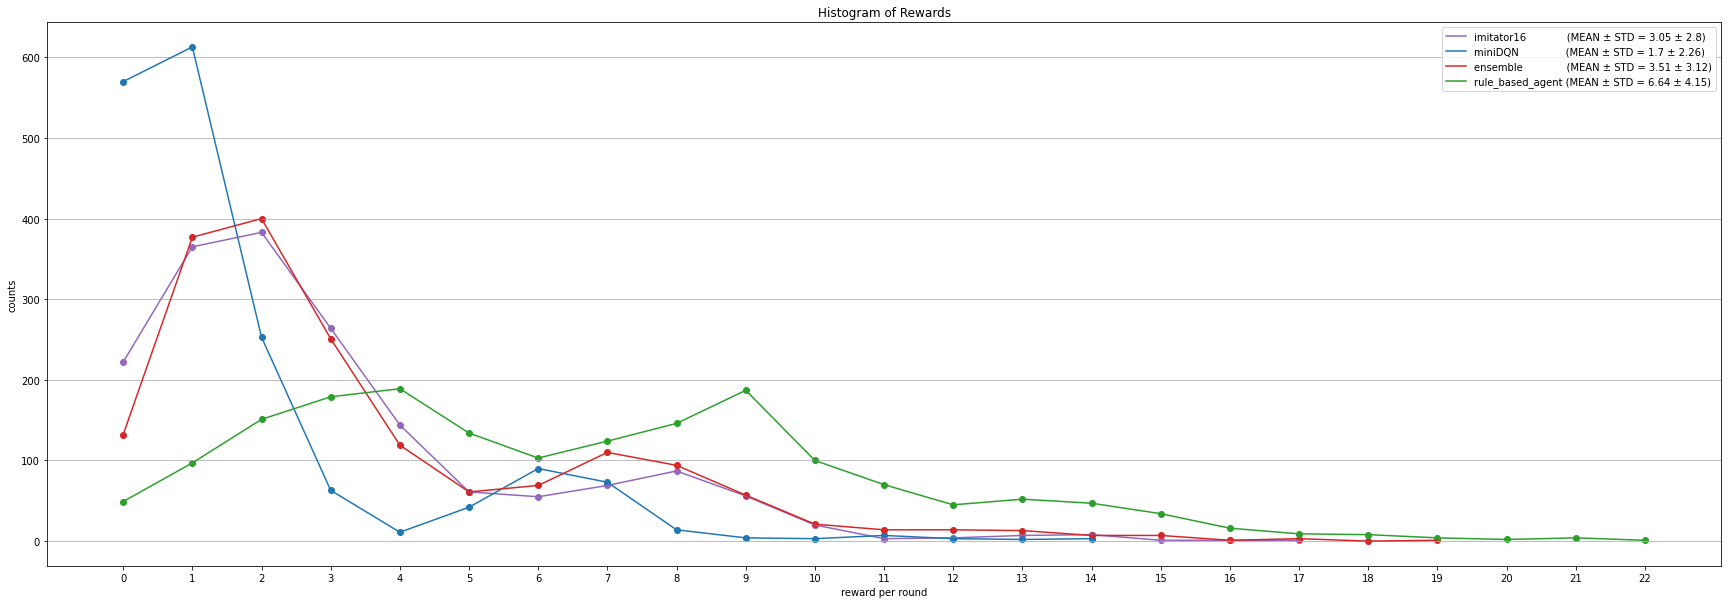

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(30, 10)); ax.set_xlabel("reward per round"); ax.set_ylabel("counts"); ax.set_title("Histogram of Rewards")
maximum_reward = np.max([np.max(rewards_each_round[k]) for k in e.keys()])
bins = np.arange(maximum_reward)
hist = {k: np.bincount(rewards_each_round[k]) for k in e.keys()}
for k in e.keys():
    # ax.hist(rewards_each_round[k], bins=bins, label=names[k], alpha=0.25);
    ax.plot(np.arange(len(hist[k])), hist[k], label=names_wide[k] + f" (MEAN ± STD = {np.round(np.mean(rewards_each_round[k]), 2)} ± {np.round(np.std(rewards_each_round[k]), 2)})")
    ax.scatter(np.arange(len(hist[k])), hist[k])

ax.set_xticks(np.arange(np.max([len(hist[k]) for k in e.keys()])))
ax.legend();
ax.grid(axis="y");

# Winrate

In [6]:
win_record = np.array([np.argmax([rewards_each_round[k][r] for k in e.keys()]) for r in range(len(rewards_each_round["e"]))])
has_won_round = np.bincount(win_record)

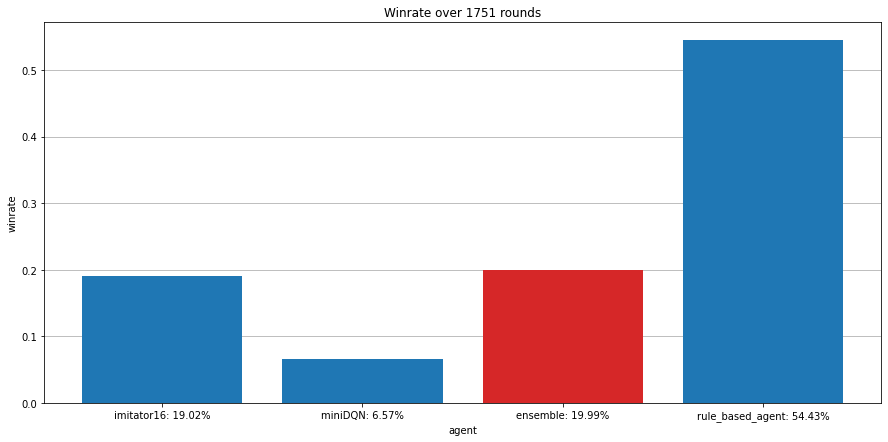

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7)); ax.set_xlabel("agent"); ax.set_ylabel("winrate"); ax.set_title(f'Winrate over {len(rewards_each_round["e"])} rounds');
ax.bar([names[k] + ": " + str(np.round(has_won_round[i] / np.sum(has_won_round) * 100, 2)) + "%" for i, k in enumerate(e.keys())], has_won_round / np.sum(has_won_round), zorder=3, color=colors_ens);
ax.grid(axis="y", zorder=0)

# Longest Round

In [8]:
had_longest_round = np.bincount([np.argmax([len(e[k]["stuck"][r]) for k in e.keys()]) for r in range(len(e["e"]["stuck"]))])

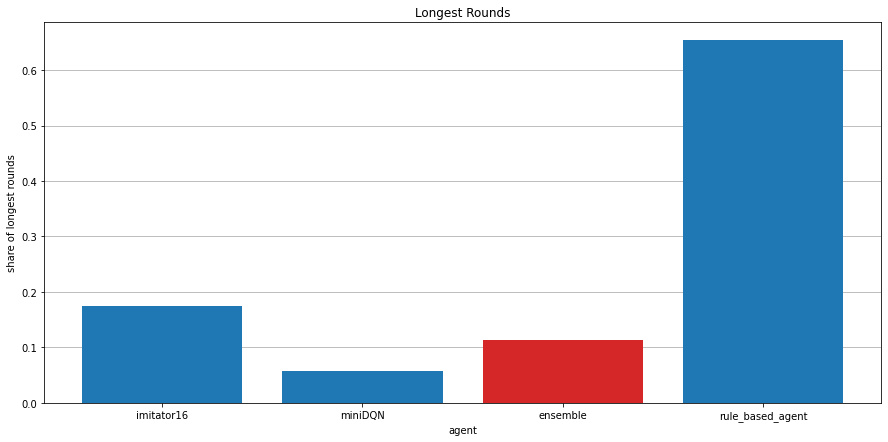

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7)); ax.set_xlabel("agent"); ax.set_ylabel("share of longest rounds"); ax.set_title("Longest Rounds");
ax.bar([names[k] for k in e.keys()], had_longest_round / np.sum(had_longest_round), zorder=3, color=colors_ens);
ax.grid(axis="y", zorder=0)

# Round length

In [10]:
round_lengths = {k: [len(r) for r in e[k]["stuck"]] for k in e.keys()}
bins = np.arange(0, 401, 10)
round_lengths_hists = {k: np.histogram(round_lengths[k], bins=bins) for k in e.keys()}

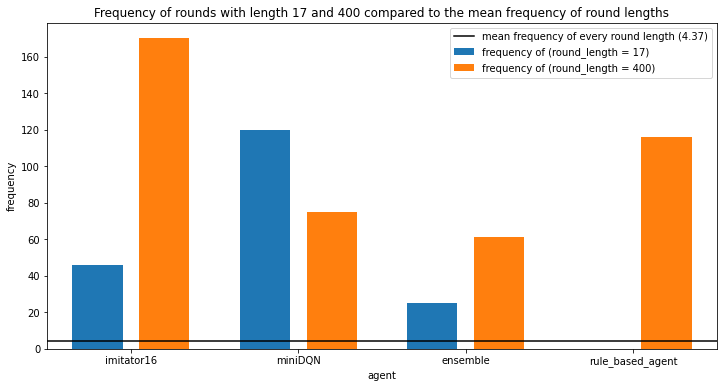

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6)); ax.set_xlabel("agent"); ax.set_ylabel("frequency"); ax.set_title("Frequency of rounds with length 17 and 400 compared to the mean frequency of round lengths")
ax.set_xticks(np.arange(4));
ax.set_xticklabels([names[k] for k in e.keys()])

# ax.bar(np.arange(4) - 0.2, [np.mean(np.bincount(round_lengths[k])) for k in e.keys()], width=0.3, color="tab:blue", label="mean frequency of every round length")
# ax.bar(np.arange(4) + 0.2, [np.mean(np.bincount(round_lengths[k])) for k in e.keys()], width=0.3, color="tab:orange", label="mean frequency of every round length")
ax.plot([-1, 4], [np.mean(np.bincount(round_lengths[k]))] * 2, color="black", label=f"mean frequency of every round length ({np.round(np.mean(np.bincount(round_lengths[k])), 2)})")

ax.bar(np.arange(4) - 0.2, [np.bincount(round_lengths[k])[17] for k in e.keys()], width=0.3, color="tab:blue", label="frequency of (round_length = 17)")
ax.bar(np.arange(4) + 0.2, [np.bincount(round_lengths[k])[400] for k in e.keys()], width=0.3, color="tab:orange", label="frequency of (round_length = 400)")

ax.legend();
ax.set_xlim(-0.5, 3.5);

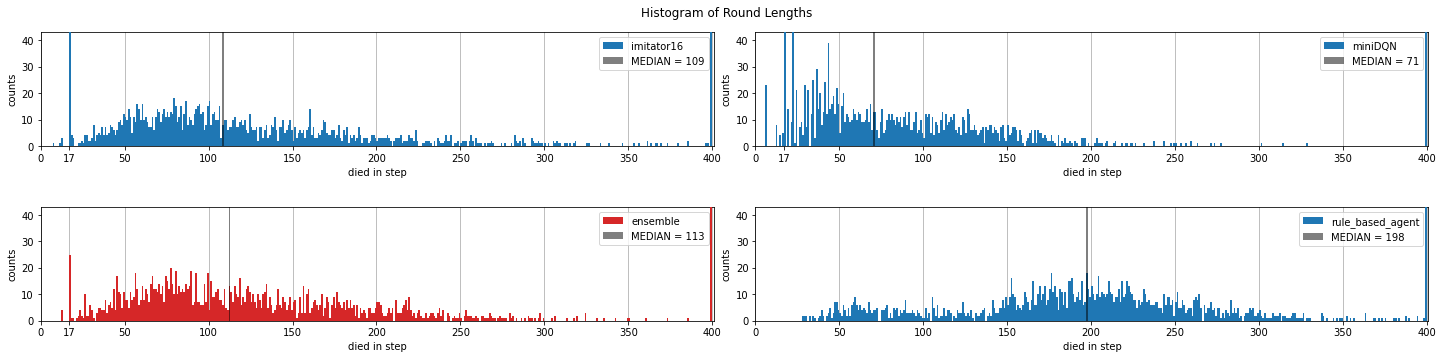

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(20, 5));
plt.tight_layout(h_pad=4.0, rect=[0, 0.03, 1, 0.95])
fig.suptitle("Histogram of Round Lengths")
for i, k in enumerate(e.keys()):
    # hist = np.bincount(round_lengths[k])
    # ax.hist(round_lengths[k], bins=np.arange(0, 401, 1), label=names[k], alpha=0.5, color=colors[i]);
    median = np.median(round_lengths[k])
    ax[i//2][i%2].hist(round_lengths[k], bins=np.arange(0, 401, 1), label=names[k], color=colors_ens[i], zorder=3)
    ax[i//2][i%2].set_xlabel("died in step"); ax[i//2][i%2].set_ylabel("counts"); #ax[i//2][i%2].set_title(names[k])
    ax[i//2][i%2].set_xlim(0, 401); ax[i//2][i%2].set_ylim(0, 43);
    ax[i//2][i%2].grid(axis="x", zorder=0)
    ax[i//2][i%2].bar([median-0.5], [50], color="black", width=1, alpha=0.5, zorder=4, label=f"MEDIAN = {int(median)}")
    if i != 3: ax[i//2][i%2].set_xticks([0, 17, 50, 100, 150, 200, 250, 300, 350, 400])
    ax[i//2][i%2].legend();

# Events

## Total

In [13]:
all_events_counter = {k:[0] * len(EVENTS) for k in e.keys()}
for k in e.keys():
    for r in e[k]["events"]:
        for s in r:
            for ev in s:
                all_events_counter[k][np.where(ev == EVENTS)[0][0]] += 1

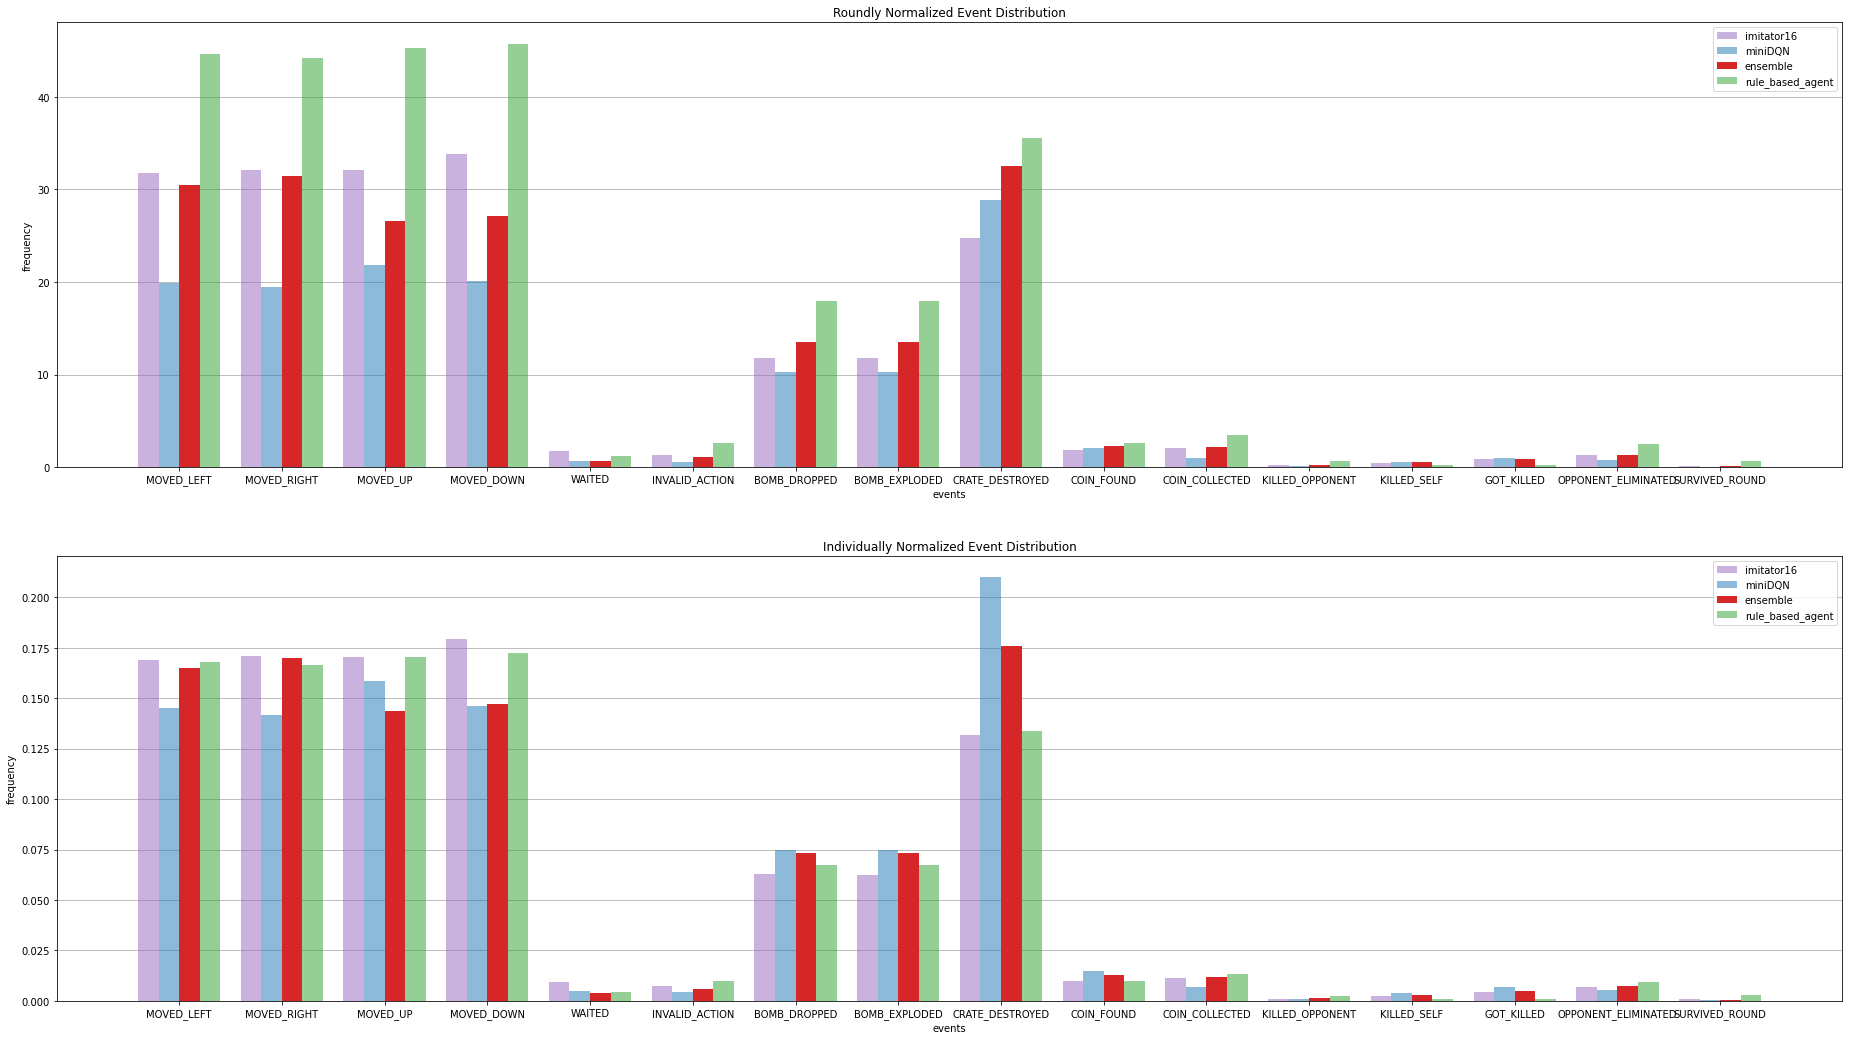

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(32, 18));

ax[0].set_title("Roundly Normalized Event Distribution")
ax[1].set_title("Individually Normalized Event Distribution")

for i, k in enumerate(e.keys()):
    ax[0].bar(np.arange(len(EVENTS)) - 0.3 + i * 0.2, np.array(all_events_counter[k]) / len(e[k]["events"]), label=names[k], width=0.2, zorder=3, alpha=(1 if k == "e" else 0.5), color=colors[i]);
    ax[1].bar(np.arange(len(EVENTS)) - 0.3 + i * 0.2, np.array(all_events_counter[k]) / np.sum(all_events_counter[k]), label=names[k], width=0.2, zorder=3, alpha=(1 if k == "e" else 0.5), color=colors[i]);
    
for axis in ax:
    axis.set_ylabel("frequency");
    axis.set_xlabel("events");
    axis.set_xticks(np.arange(len(EVENTS)))
    axis.set_xticklabels(EVENTS)
    axis.legend();
    axis.grid(axis="y", zorder=0);

## In step 17

In [15]:
all_events_counter_17 = {k:[0] * len(EVENTS) for k in e.keys()}
total_n_rounds_with_len_17 = {k: 0 for k in e.keys()}
for k in e.keys():
    for r in e[k]["events"]:
        if len(r) == 17:
            total_n_rounds_with_len_17[k] += 1
            for s in r:
                for ev in s:
                    all_events_counter_17[k][np.where(ev == EVENTS)[0][0]] += 1

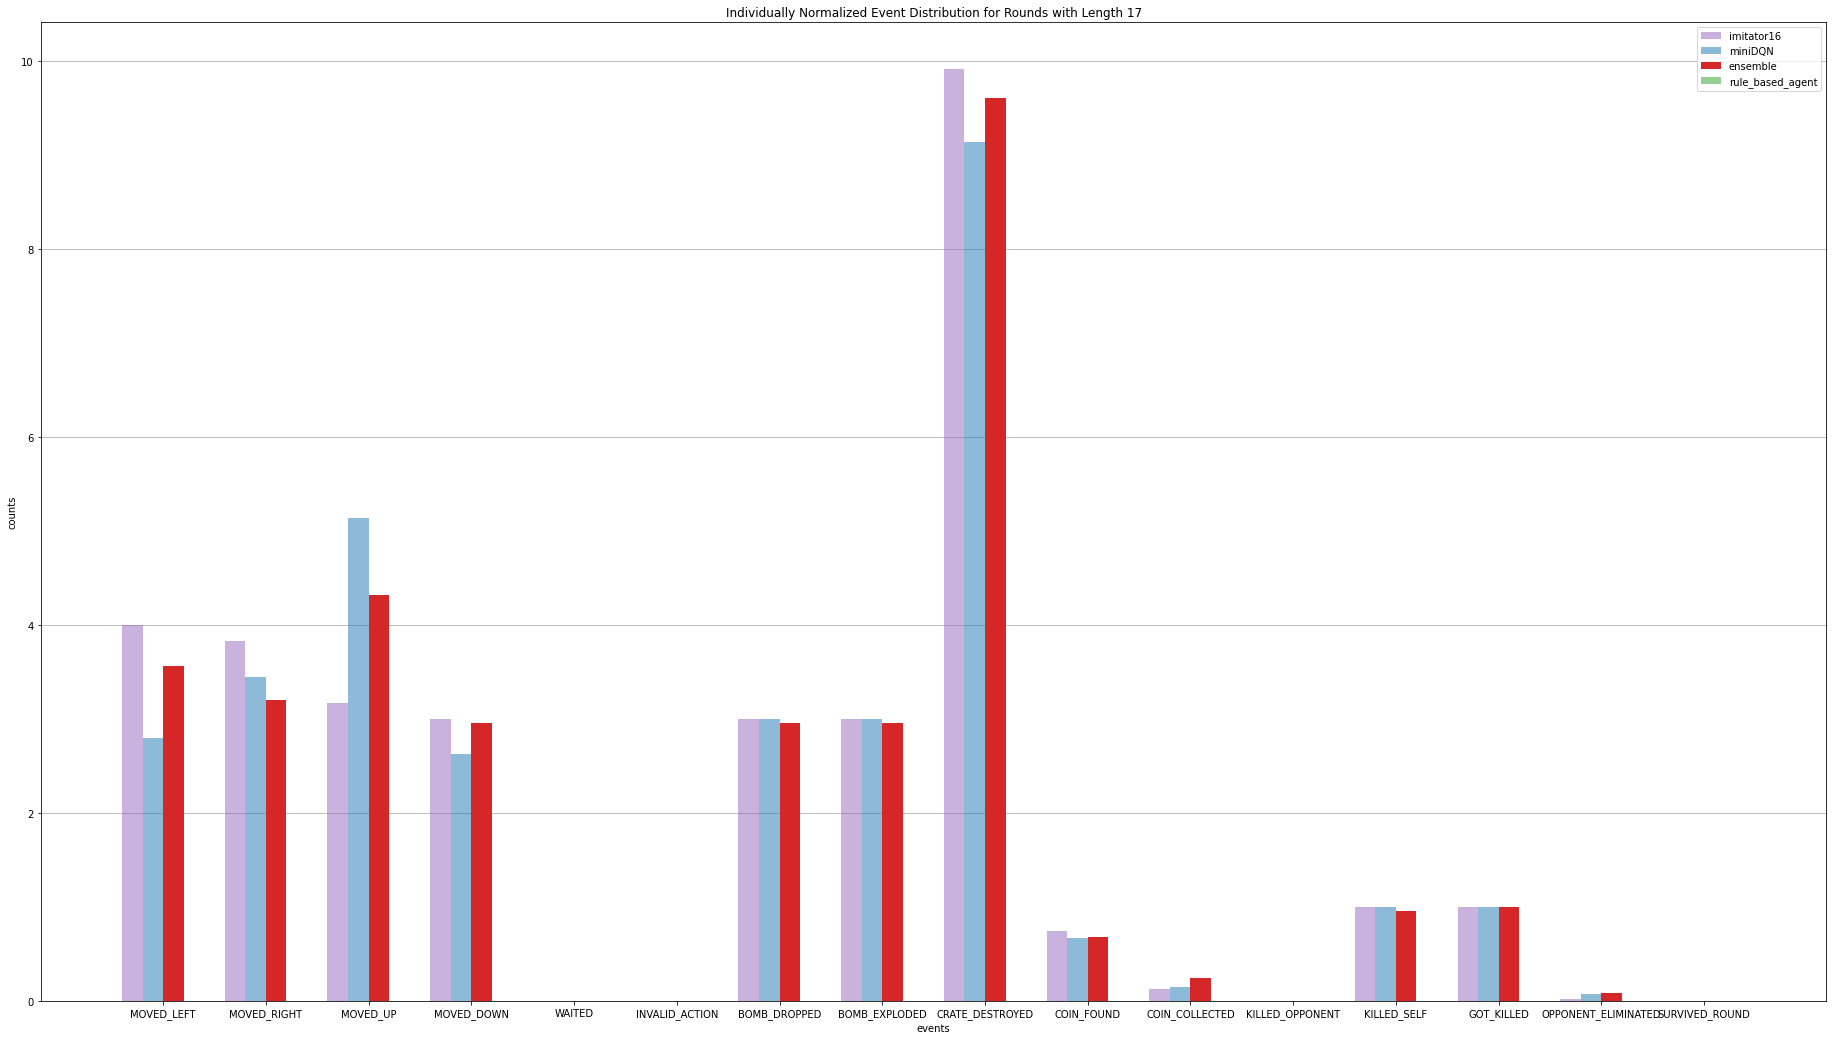

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(32, 7)); ax.set_xlabel("events"); ax.set_ylabel("counts"); ax.set_title("Individually Normalized Event Distribution for Rounds with Length 17")
for i, k in enumerate(e.keys()):
    ax.bar(np.arange(len(EVENTS)) - 0.3 + i * 0.2, np.array(all_events_counter_17[k]) / max(1, total_n_rounds_with_len_17[k]), label=names[k], width=0.2, zorder=3, alpha=(1 if k == "e" else 0.5), color=colors[i]);
    ax.set_xticks(np.arange(len(EVENTS)))
    ax.set_xticklabels(EVENTS)
ax.legend();
ax.grid(axis="y", zorder=0);

## Suicide Rate and Value

In [17]:
all_rewards_in_suicide_step = {k: [] for k in e.keys()}
all_suicide_steps = {k: [] for k in e.keys()}

for k in e.keys():
    for r in e[k]["events"]:
        all_suicide_steps[k].append(len(r))
        all_rewards_in_suicide_step[k].append(0)
        for ev in r[-1]:
            if ev == "COIN_COLLECTED": all_rewards_in_suicide_step[k][-1] += 1
            if ev == "KILLED_OPPONENT": all_rewards_in_suicide_step[k][-1] += 1

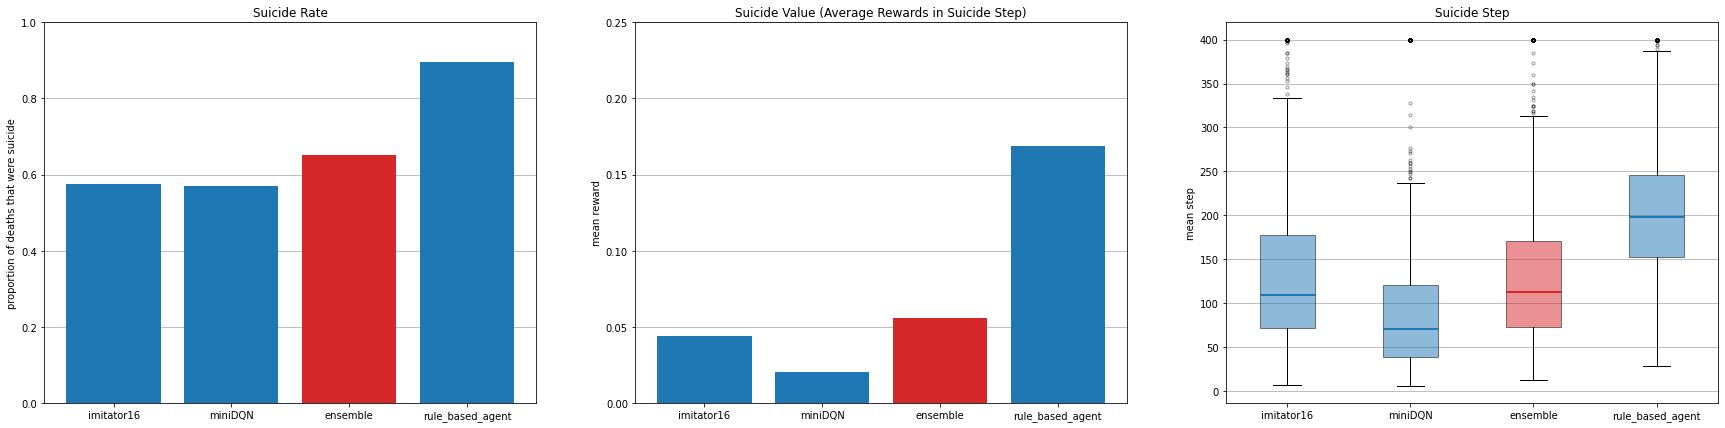

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(30, 7));
ax[0].set_title("Suicide Rate"); ax[0].set_ylabel("proportion of deaths that were suicide"); ax[0].set_ylim(0, 1); ax[0].grid(axis="y", zorder=0)
ax[0].bar([names[k] for k in e.keys()], [all_events_counter[k][np.where(EVENTS == "KILLED_SELF")[0][0]] / all_events_counter[k][np.where(EVENTS == "GOT_KILLED")[0][0]] for k in e.keys()], zorder=3, color=colors_ens);

ax[1].set_title("Suicide Value (Average Rewards in Suicide Step)"); ax[1].set_ylabel("mean reward"); ax[1].grid(axis="y", zorder=0); ax[1].set_ylim(0, 0.25)
ax[1].bar([names[k] for k in e.keys()], [np.mean(all_rewards_in_suicide_step[k]) for k in e.keys()], zorder=3, color=colors_ens);

ax[2].set_title("Suicide Step"); ax[2].set_ylabel("mean step"); ax[2].grid(axis="y", zorder=0); #ax[2].set_ylim(130, 230)
bp = ax[2].boxplot([all_suicide_steps[k] for k in e.keys()], zorder=3, patch_artist = True);
for c, median, box in zip(colors_ens, bp['medians'], bp["boxes"]):
    median.set(color=c, linewidth=2, solid_capstyle="butt");
    box.set_facecolor(c)
    box.set_alpha(0.5)
for flier in bp['fliers']: 
    flier.set(marker='.',  color=colors_ens[0], alpha = 0.4) 
ax[2].set_xticks(np.arange(4)+1)
ax[2].set_xticklabels([names[k] for k in e.keys()]);

## Bomb efficiency

In [19]:
all_action_proposed = {k: [] for k in e.keys()}
for k in e.keys():
    for r in e[k]["action_proposed"]:
        all_action_proposed[k].extend(r)

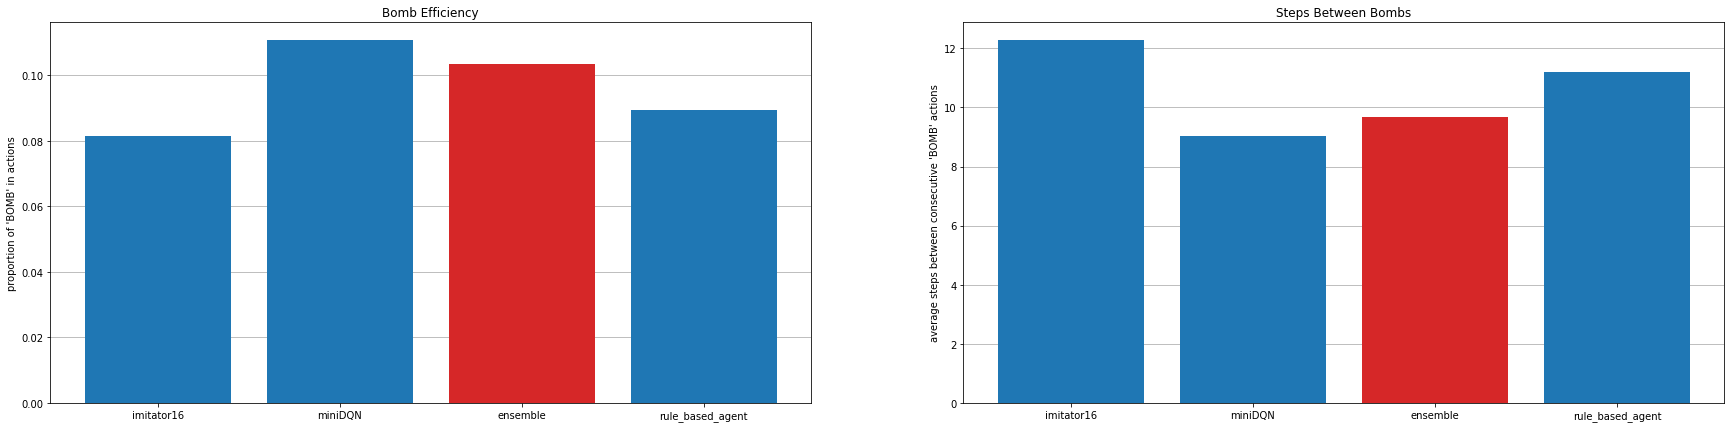

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(30, 7));
for axis in ax:
    axis.grid(axis="y", zorder=0)

ax[0].set_title("Bomb Efficiency"); 
ax[0].set_ylabel("proportion of 'BOMB' in actions")
ax[0].bar([names[k] for k in e.keys()], [np.mean(np.array(all_action_proposed[k]) == 5) for k in e.keys()], zorder=3, color=colors_ens)
ax[1].set_title("Steps Between Bombs"); 
ax[1].set_ylabel("average steps between consecutive 'BOMB' actions")
ax[1].bar([names[k] for k in e.keys()], [1 / np.mean(np.array(all_action_proposed[k]) == 5) for k in e.keys()], zorder=3, color=colors_ens);

# Times Stuck per Round

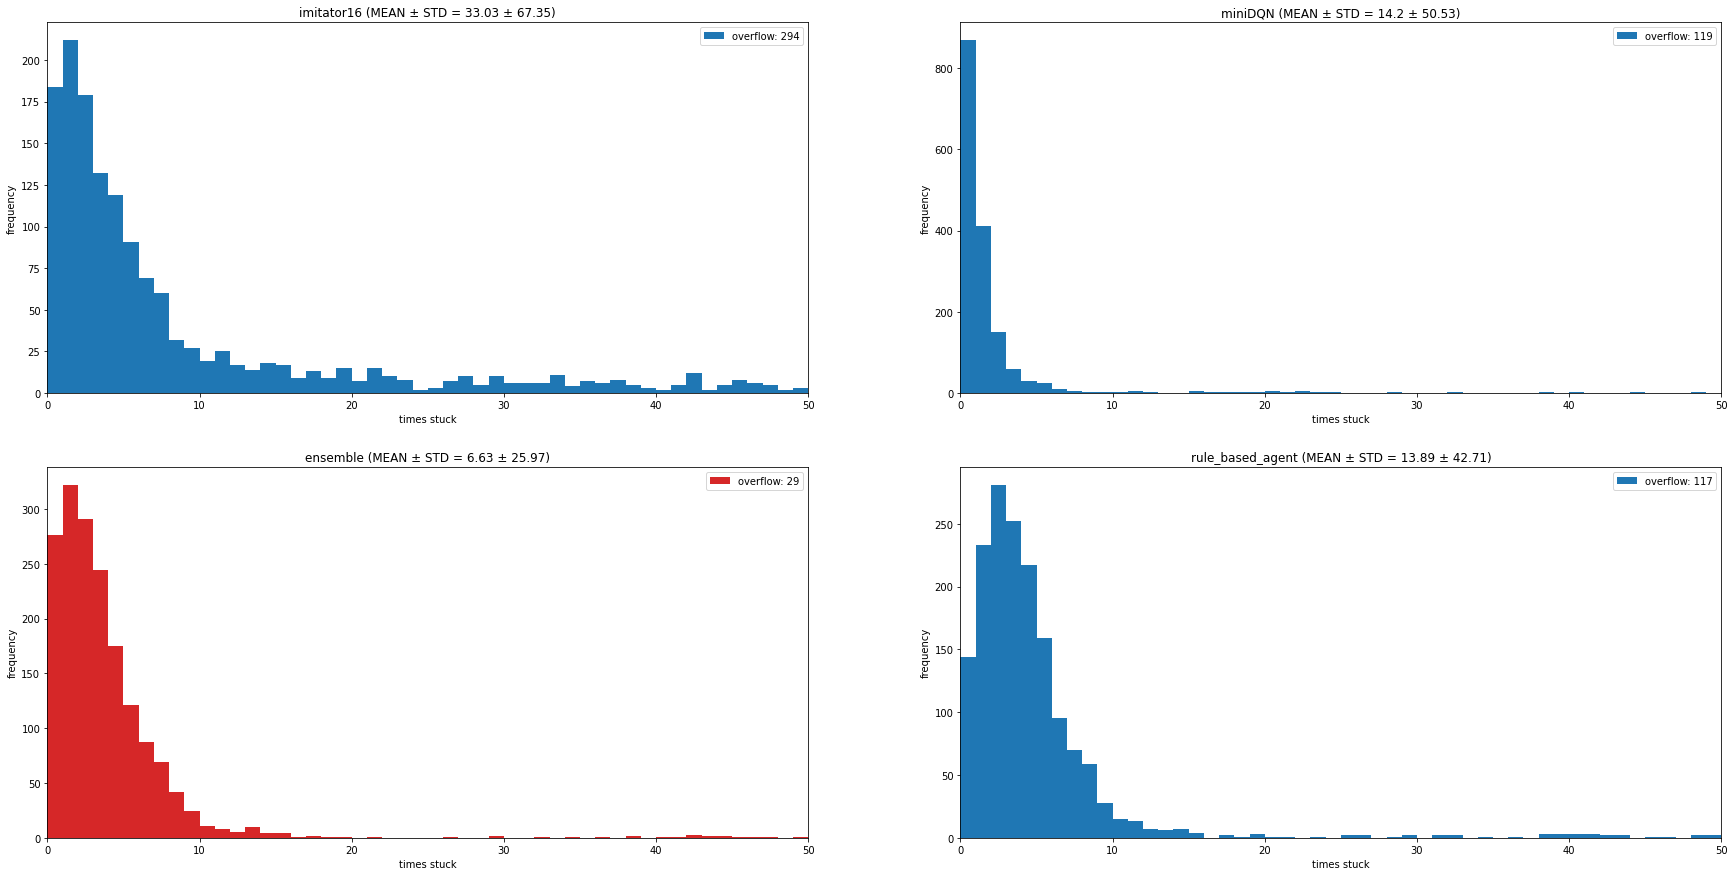

In [21]:
times_stuck_in_each_round = {k: [sum(r) for r in e[k]["stuck"]] for k in e.keys()}
fig, ax = plt.subplots(2, 2, figsize=(30, 15)); 
cutoff = 50
# fig.suptitle(f"Times Stuck per Round")
for i, k in enumerate(e.keys()):
    ax[i//2][i%2].set_xlabel("times stuck"); ax[i//2][i%2].set_ylabel("frequency");
    ax[i//2][i%2].set_xlim(0, cutoff)#np.max([np.max(times_stuck_in_each_round[k]) for k in e.keys()]))
    ax[i//2][i%2].set_title(names[k] + f" (MEAN ± STD = {np.round(np.mean(times_stuck_in_each_round[k]), 2)} ± {np.round(np.std(times_stuck_in_each_round[k]), 2)})")
    ax[i//2][i%2].hist(times_stuck_in_each_round[k], bins=np.arange(0, np.max([np.max(times_stuck_in_each_round[k]) for k in e.keys()])), label=f"overflow: {np.sum(np.array(times_stuck_in_each_round[k]) > cutoff)}", color=colors_ens[i]);
    ax[i//2][i%2].legend();

# Round Lengths vs Times Stuck per Round

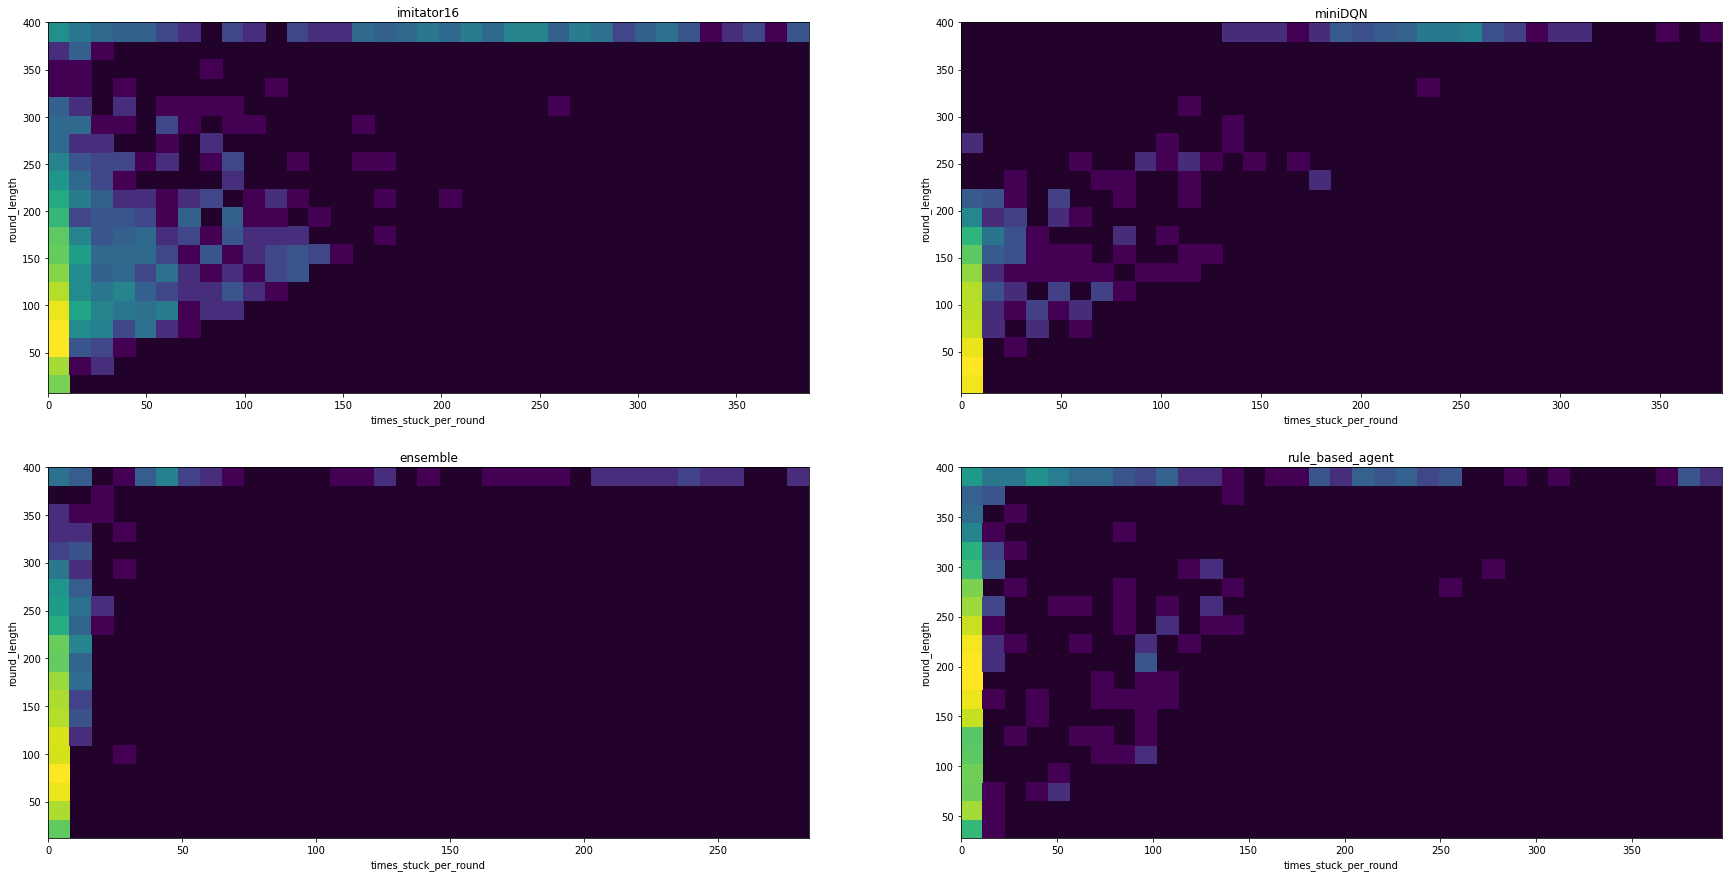

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(30, 15));
# fig.suptitle("Round Lengths vs Times Stuck per Round")
for i, k in enumerate(e.keys()):
    ax[i//2][i%2].set_facecolor(tuple(color0))
    ax[i//2][i%2].set_ylabel("round_length"); ax[i//2][i%2].set_xlabel("times_stuck_per_round")
    ax[i//2][i%2].set_title(names[k])
    ax[i//2][i%2].hist2d(times_stuck_in_each_round[k], round_lengths[k], bins=(35, 20), norm=LogNorm());

# Log Impact of Being Stuck on Reward

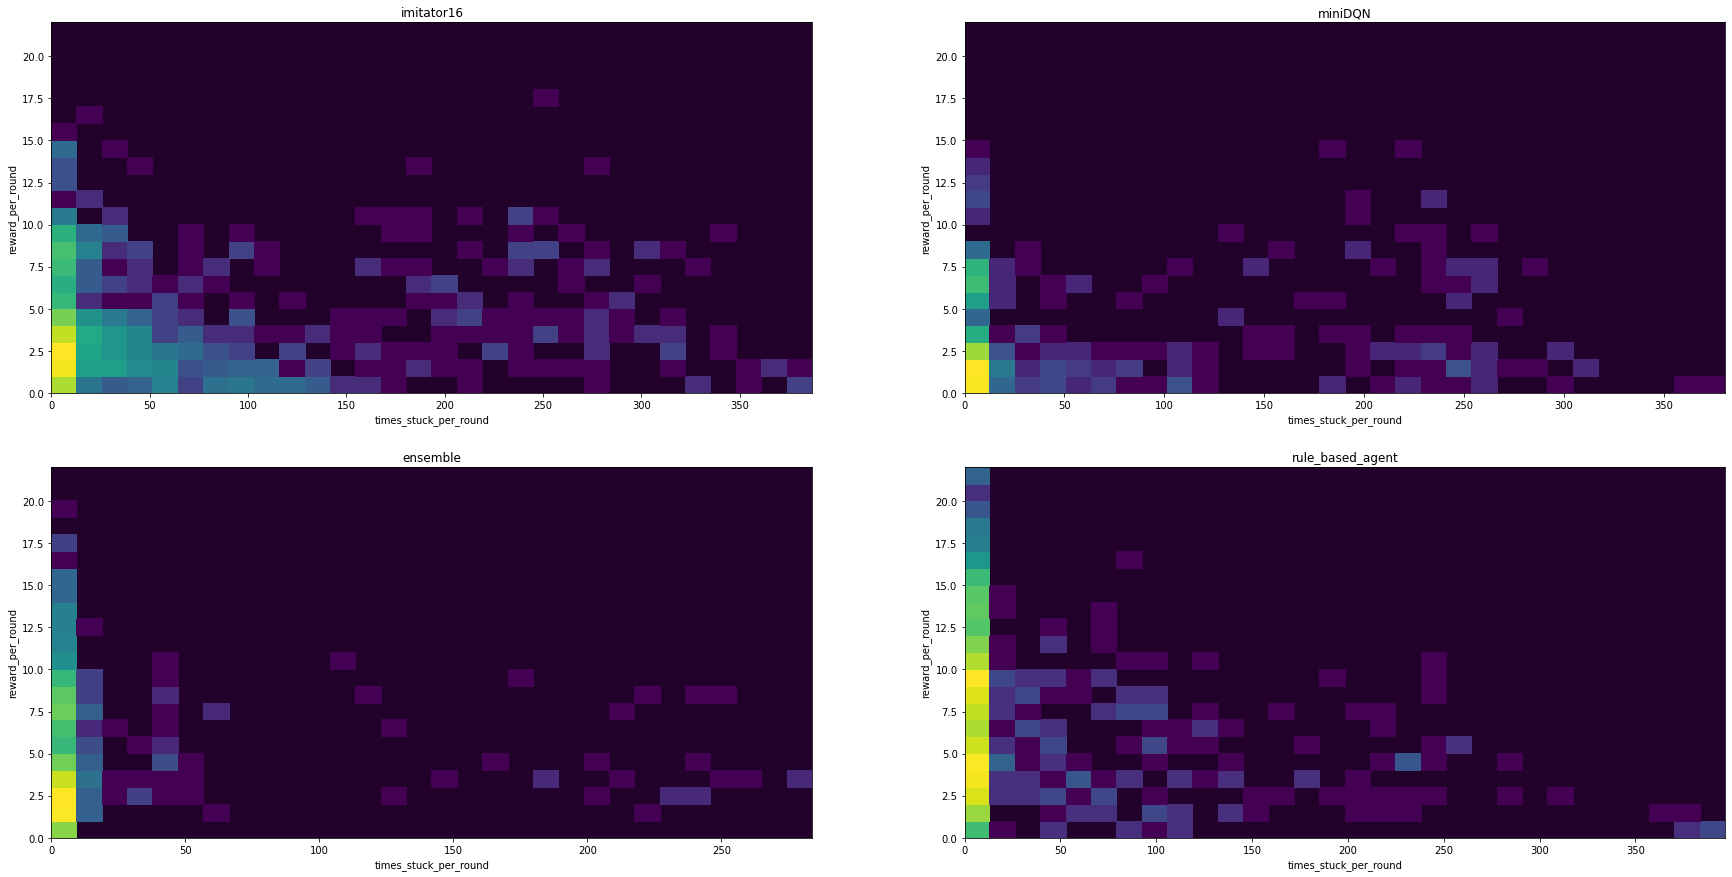

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(30, 15));
# fig.suptitle("Impact of Being Stuck on Reward")
for i, k in enumerate(e.keys()):
    ax[i//2][i%2].set_facecolor(tuple(color0))
    ax[i//2][i%2].set_ylabel("reward_per_round"); ax[i//2][i%2].set_xlabel("times_stuck_per_round");
    ax[i//2][i%2].set_title(names[k])
    ax[i//2][i%2].hist2d(times_stuck_in_each_round[k], rewards_each_round[k], bins=(30, np.arange(0, maximum_reward + 1)), norm=LogNorm());
    ax[i//2][i%2].set_ylim(0, maximum_reward)

# Accordance

## All steps

In [24]:
all_proposed_action_imitator = []
all_proposed_action_imitator_won = []
for winning_agent, r in zip(win_record, e["e"]["proposed_action_imitator"]):
    all_proposed_action_imitator.extend(r)
    all_proposed_action_imitator_won.extend([winning_agent == 2 for _ in r])

all_proposed_action_miniDQN = []
all_proposed_action_miniDQN_won = []
for winning_agent, r in zip(win_record, e["e"]["proposed_action_miniDQN"]):
    all_proposed_action_miniDQN.extend(r)
    all_proposed_action_miniDQN_won.extend([winning_agent == 2 for _ in r])

In [25]:
print(f"The imitator and the miniDQN were in agreement in {np.round(np.mean(np.array(all_proposed_action_imitator) == np.array(all_proposed_action_miniDQN)) * 100, 1)}% of all steps.")

The imitator and the miniDQN were in agreement in 55.2% of all steps.


In [26]:
all_proposed_actions = []
for r in e["e"]["action_proposed"]:
    all_proposed_actions.extend(r)

In [27]:
print(f"The action proposed by the imitator was also proposed by the emsemble in {np.round(np.mean(np.array(all_proposed_action_imitator) == np.array(all_proposed_actions)) * 100, 1)}% of all steps.")
print(f"The action proposed by the miniDQN  was also proposed by the emsemble in {np.round(np.mean(np.array(all_proposed_action_miniDQN) == np.array(all_proposed_actions)) * 100, 1)}% of all steps.")

The action proposed by the imitator was also proposed by the emsemble in 85.8% of all steps.
The action proposed by the miniDQN  was also proposed by the emsemble in 68.0% of all steps.


## Round Won vs Round Lost

In [28]:
print(f"In rounds the ensemble won,  the imitator and the miniDQN were in agreement in {np.round(np.mean(np.array(all_proposed_action_imitator)[all_proposed_action_imitator_won] == np.array(all_proposed_action_miniDQN)[all_proposed_action_miniDQN_won]) * 100, 1)}% of all steps.")
print(f"In rounds the ensemble lost, the imitator and the miniDQN were in agreement in {np.round(np.mean(np.array(all_proposed_action_imitator)[np.logical_not(all_proposed_action_imitator_won)] == np.array(all_proposed_action_miniDQN)[np.logical_not(all_proposed_action_miniDQN_won)]) * 100, 1)}% of all steps.")

In rounds the ensemble won,  the imitator and the miniDQN were in agreement in 54.9% of all steps.
In rounds the ensemble lost, the imitator and the miniDQN were in agreement in 55.3% of all steps.


# Action Validity

In [29]:
all_proposed_action_imitator_were_valid = {k: [] for k in e.keys()}
for k in e.keys():
    for r in e[k]["proposed_action_imitator_was_valid"]:
        all_proposed_action_imitator_were_valid[k].extend(r)

all_proposed_action_miniDQN_were_valid = {k: [] for k in e.keys()}
for k in e.keys():
    for r in e[k]["proposed_action_miniDQN_was_valid"]:
        all_proposed_action_miniDQN_were_valid[k].extend(r)

In [30]:
print("Imitator:")
print(f'{np.round(np.mean(all_proposed_action_imitator_were_valid["i"]) * 100, 1)}% of the proposed actions of the imitator were valid.\n')

print("miniDQN:")
print(f'{np.round(np.mean(all_proposed_action_miniDQN_were_valid["m"]) * 100, 1)}% of the proposed actions of the miniDQN  were valid.\n')

print("Ensemble:")
print(f'{np.round(np.mean(all_proposed_action_imitator_were_valid["e"]) * 100, 1)}% of the proposed actions of the imitator were valid.')
print(f'{np.round(np.mean(all_proposed_action_miniDQN_were_valid["e"]) * 100, 1)}% of the proposed actions of the miniDQN  were valid.')

Imitator:
99.8% of the proposed actions of the imitator were valid.

miniDQN:
86.0% of the proposed actions of the miniDQN  were valid.

Ensemble:
99.6% of the proposed actions of the imitator were valid.
92.6% of the proposed actions of the miniDQN  were valid.


# Confidence

In [31]:
all_confidence_imitator = {k: [] for k in e.keys()}
for k in e.keys():
    for r in e[k]["confidence_imitator"]:
        all_confidence_imitator[k].extend(r)

all_confidence_miniDQN = {k: [] for k in e.keys()}
for k in e.keys():
    for r in e[k]["confidence_miniDQN"]:
        all_confidence_miniDQN[k].extend(r)

all_confidence_ensemble = []
for r in e["e"]["normalized_confidence_ensemble"]:
    r = np.array(r)
    r[np.isnan(r)] = 0
    all_confidence_ensemble.extend(r)

In [32]:
print("Imitator:")
print(f'Confidence of the imitator: MEAN ± STD = {np.round(np.mean(all_confidence_imitator["i"]), 2):.2f} ± {np.round(np.std(all_confidence_imitator["i"]), 2):.2f}\n')

print("miniDQN:")
print(f'Confidence of the miniDQN : MEAN ± STD = {np.round(np.mean(all_confidence_miniDQN["m"]), 2):.2f} ± {np.round(np.std(all_confidence_miniDQN["m"]), 2):.2f}\n')

print("Ensemble:")
print(f'Confidence of the imitator: MEAN ± STD = {np.round(np.mean(all_confidence_imitator["e"]), 2):.2f} ± {np.round(np.std(all_confidence_imitator["e"]), 2):.2f}')
print(f'Confidence of the miniDQN : MEAN ± STD = {np.round(np.mean(all_confidence_miniDQN["e"]), 2):.2f} ± {np.round(np.std(all_confidence_miniDQN["e"]), 2):.2f}')
print(f'Normalized confidence of the ensemble: MEAN ± STD = {np.round(np.mean(all_confidence_ensemble), 2):.2f} ± {np.round(np.std(all_confidence_ensemble), 2):.2f}')

Imitator:
Confidence of the imitator: MEAN ± STD = 0.85 ± 0.19

miniDQN:
Confidence of the miniDQN : MEAN ± STD = 0.57 ± 0.19

Ensemble:
Confidence of the imitator: MEAN ± STD = 0.87 ± 0.18
Confidence of the miniDQN : MEAN ± STD = 0.60 ± 0.19
Normalized confidence of the ensemble: MEAN ± STD = 0.90 ± 0.15


## Confidence Weighted Events

In [33]:
all_event_confidences_imitator = [[] for _ in range(len(EVENTS))]
all_event_confidences_miniDQN = [[] for _ in range(len(EVENTS))]
all_event_confidences_ensemble_i= [[] for _ in range(len(EVENTS))]
all_event_confidences_ensemble_m = [[] for _ in range(len(EVENTS))]
all_event_confidences_ensemble = [[] for _ in range(len(EVENTS))]

for round_confidences, round_events in zip(e["i"]["confidence_imitator"], e["i"]["events"]):
    for confidence, events in zip(round_confidences, round_events):
        for ev in events:
            all_event_confidences_imitator[np.where(ev == EVENTS)[0][0]].append(confidence)

for round_confidences, round_events in zip(e["m"]["confidence_miniDQN"], e["m"]["events"]):
    for confidence, events in zip(round_confidences, round_events):
        for ev in events:
            all_event_confidences_miniDQN[np.where(ev == EVENTS)[0][0]].append(confidence)

for round_confidences, round_events in zip(e["e"]["confidence_imitator"], e["e"]["events"]):
    for confidence, events in zip(round_confidences, round_events):
        for ev in events:
            all_event_confidences_ensemble_i[np.where(ev == EVENTS)[0][0]].append(confidence)

for round_confidences, round_events in zip(e["e"]["confidence_miniDQN"], e["e"]["events"]):
    for confidence, events in zip(round_confidences, round_events):
        for ev in events:
            all_event_confidences_ensemble_m[np.where(ev == EVENTS)[0][0]].append(confidence)

for round_confidences, round_events in zip(e["e"]["normalized_confidence_ensemble"], e["e"]["events"]):
    for confidence, events in zip(round_confidences, round_events):
        if np.isnan(confidence): continue
        for ev in events:
            all_event_confidences_ensemble[np.where(ev == EVENTS)[0][0]].append(confidence)

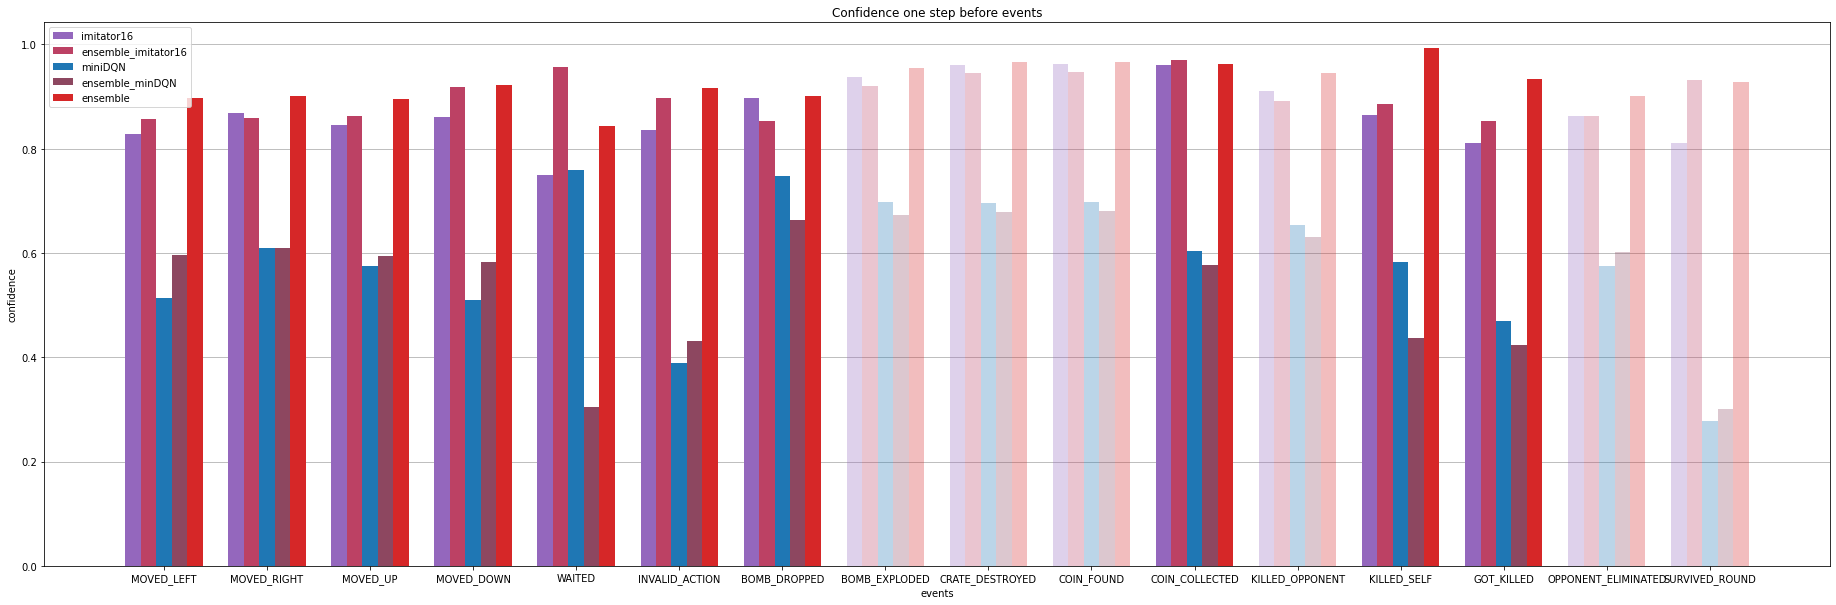

In [34]:
def fade_out_colors(color):
    faded_colors = []
    for i in range(len(EVENTS)):
        if i in [0, 1, 2, 3, 4, 5, 6, 10, 12, 13]:
            faded_colors.append(color)
        else:
            faded_colors.append((color[0], color[1], color[2], 0.3))
    return faded_colors

fig, ax = plt.subplots(1, 1, figsize=(32, 10)); ax.set_title("Confidence one step before events")

for i, (event_conf, name) in enumerate(zip([all_event_confidences_imitator, all_event_confidences_ensemble_i, all_event_confidences_miniDQN, all_event_confidences_ensemble_m, all_event_confidences_ensemble], ["imitator16", "ensemble_imitator16", "miniDQN", "ensemble_minDQN", "ensemble"])):

    ax.bar(np.arange(len(EVENTS)) - 0.3 + i * 0.15, [np.mean(event_conf[ev]) for ev in range(len(EVENTS))], label=name, width=0.15, zorder=3, color=fade_out_colors(colors_grad[i]));
    
ax.set_ylabel("confidence");
ax.set_xlabel("events");
ax.set_xticks(np.arange(len(EVENTS)))
ax.set_xticklabels(EVENTS)
ax.legend();
ax.grid(axis="y", zorder=0);